# Marked exercises after Lecture 5
This notebook contains the marked exercises with instructions and explanations.

Work through the cells below in sequential order, executing each cell as you progress. Throughout the notebook, you will encounter instructions marked with the words **YOUR CODE HERE** followed by **raise NotImplementedError()**. You will have to substitute  *raise NotImplementedError()* with your own code.
Follow the instructions and write the code to complete the tasks.

Along the way, you may also find questions. Try to reflect on the questions before/after running the code.

You have multiple exercises to complete. In total, you can get **20 points** out of 60 points for Submission 1 for completing all marked exercises related to lecture 5.

This notebook was developed at the [Idiap Research Institute](https://www.idiap.ch) by [Alina Elena Baia](mailto:alina.baia.idiap.ch>), [Darya Baranouskaya](mailto:darya.baranouskaya.idiap.ch) and [Olena Hrynenko](mailto:olena.hrynenko.idiap.ch) (equal contribution). Any reproduction or distribution of this document, in whole or in part, is prohibited unless permission is granted by the authors.
<!--
SPDX-FileCopyrightText: Copyright (c) 2019-2025 Idiap Research Institute <contact@idiap.ch>
SPDX-FileContributor: Alina Elena Baia <alina.baia.idiap.ch>
SPDX-FileContributor: Darya Baranouskaya <darya.baranouskaya.idiap.ch>
SPDX-FileContributor: Olena Hrynenko <olena.hrynenko.idiap.ch>
-->

The transformer model relies on three key components: positional encoding, scaled-dot-product attention, and multi-head attention.  

**Scaled dot product**  enhances text embeddings by incorporating relevant information from neighbouring tokens, allowing the model to learn which words have the most influence on each other. **Multi-head attention**  applies this concept multiple times, enabling the model to capture various types of relationships between tokens and improving its representation power.

However, these mechanisms lack awareness of token order, which is crucial for understanding sequences. This limitation is addressed by **positional encodings**, which can be absolute or relative. In this exercise, you will get familiar with **absolute positional encoding** (introduced in the "Attention is all you need" paper) and **Rotary Positional Embedding** (introduced in "RoFormer: Enhanced Transformer with Rotary Position Embedding"), which are used in modern large language models like Llama.

Sources that you will need for this marked exercise:

* [1] A. Vaswani et al., “Attention is all you need,” Advances in neural information processing systems, vol. 30, 2017. Available at: https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf

* [2] J. Su, M. Ahmed, Y. Lu, S. Pan, W. Bo, and Y. Liu, “Roformer: Enhanced transformer with rotary position embedding,” Neurocomputing, vol. 568, p. 127063, 2024. Available at: https://arxiv.org/pdf/2104.09864



Note that you are NOT ALLOWED to use toolboxes that automatically solve the main tasks of the assignment, such as (but not limited to) `nn.MultiheadAttention`.
You are NOT ALLOWED to use any other libraries besides `torch` and `torch.nn`, `matplotlib.pyplot`, and `seaborn` in this notebook.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

## Attention
Read [1] and implement Absolute Positional Encoding, Scaled dot-product, Multi-head attention.

##### 1.5.1 Scaled dot-product attention [2 points]

'An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$.'

The input of the non-batched scaled dot-product attention is 3 matrixes: queries $Q\in\mathbb{R}^{L\times d_k}$, keys $K\in\mathbb{R}^{S\times d_k}$  and values  $V\in\mathbb{R}^{S\times d_v}$, where $L$ and $S$ represent sequences length (for example, number of tokens in the query and key sequences), and $d_k,d_k, d_v$ are the dimensions of query, key, value correspondingly.

So, query is a sequence of $L$ token embeddings, each token of dimension $d_k$, key is a sequence of $S$ token embeddings, each token of dimension $d_k$, and value is a sequence of $S$ token embeddings, each token of dimension $d_v$.

Scaled dot-product attention is computed as:
$$ \text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

Note that your implementation should work for batched inputs.


In [2]:
def scaled_dot_product(value, query, key):
    """
    Args:
        value: torch.Tensor (..., S, d_v)
        query: torch.Tensor (..., L, d_k)
        key: torch.Tensor (..., S, d_k)

    Returns:
        attn: torch.Tensor (..., L, d_v), output of the scaled dot-product attention
        attn_weights: torch.Tensor (..., L, d_v), attention weights

    L is the length of the query sequence
    S is the length of the key and value sequences, d_k and d_v are the embedding dimensions

    ... is a placeholder to denote other dimensions.
    The scaled_dot_product should be computed on the last and second-to-last dimensions.
    Every element in ...dimension should be processed independently (torch.matmul operations allow that to happen).
    For example, ... can represent a batch size B and the vector query will have a size (B, L, d_k),
    then the output should be a size of (B, L, d_v) where every batch is processed independently from other batches
    """
    #TODO implement scaled dot product
    # YOUR CODE HERE
    d_k = query.shape[-1]
    scale = torch.sqrt(torch.tensor(d_k, dtype=query.dtype, device=query.device))
    scores = torch.matmul(query, key.transpose(-2, -1)) / scale
    attn_weights = F.softmax(scores, dim=-1)
    attn = torch.matmul(attn_weights, value)  
    return attn, attn_weights

In [3]:
# Check your implementation
#epsilon to check your results
epsilon = 1e-3
epsilon_2 = 1e-6
#example 1
query  = torch.Tensor([[1, 2, 3],
                       [3, 2, 1],
                       [1, 3, 2]])
key  = torch.Tensor([[3, 2, 1],
                     [1, 2, 3],
                     [1, 2, 3]])
value  = torch.Tensor([[1, 1, 1],
                       [1, 1, 1],
                       [1, 1, 1]])

answer, attn_weights = scaled_dot_product(value, query, key)
answer
correct = torch.Tensor([[1.0000, 1.0000, 1.000],
                        [1.0000, 1.0000, 1.0000],
                        [1.0000, 1.0000, 1.0000]])

assert (torch.all(answer + epsilon >= correct)) and (torch.all(answer - epsilon <= correct))
assert (torch.all(attn_weights.sum(dim=1) + epsilon_2 >= torch.ones(3))) and (torch.all(attn_weights.sum(dim=1) - epsilon_2 <= torch.ones(3)))


##### 1.5.2 Multi-Head attention [8 points]

For the multi-head attention the dimension of queries, keys and values are equal to $d\_model$.

'Instead of performing a single attention function with d_model-dimensional keys, values and queries, we found it beneficial to linearly project the queries, keys and values $h$ times with different, learned linear projections to $d\_k$, $d\_k$ and $d\_v$ dimensions, respectively. On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding $d_v$ -dimensional output values. These are concatenated and once again projected, resulting in the final values.

$$
\begin{split}\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where } \text{head}_i & = \text{Attention}(QW_i^Q,KW_i^K, VW_i^V)
\end{split}\end{split}
$$


Where the projections are parameter matrices $W_i^Q \in R^{d\_model ×d\_k}$, $W_i^K \in R^{d\_model ×d\_k}$, $W_i^V \in R^{d\_model ×d\_v}$ and $W^O \in R^{h*d\_v ×d\_model}$

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.'

You are NOT allowed to iterate through the heads with the FOR loop. Instead, you need to reshape the linear projections of key query and value to compute the scaled dot product utilising the `scaled_dot_product` function.


In [4]:
class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, h, d_model, d_k, d_v):
        '''
        d_model: dimensionality of embeddings (total)
        h: number of heads
        d_k: dimensionality of one linear projections of query
        d_v: dimensionality of one linear projections on value
        '''
        super().__init__()
        assert d_model % h == 0
        assert d_model // d_v == h #we want the output to have the same dimensionality d_model as the inputs

        # Note: no bias is needed when linear projections are performed
        self.num_heads = h
        self.d_k = d_k
        self.d_v = d_v
        self.d_model = d_model

        # YOUR CODE HERE
        self.W_q = nn.Linear(d_model, h * d_k, bias=False)
        self.W_k = nn.Linear(d_model, h * d_k, bias=False)
        self.W_v = nn.Linear(d_model, h * d_v, bias=False)
        self.W_o = nn.Linear(h * d_v, d_model, bias=False)

    def forward(self, q, k, v):
        '''
        Args:
            query: torch.Tensor (Batch_size, L, d_model)
            key: torch.Tensor (Batch_size, S, d_model)
            value: torch.Tensor (Batch_size, S, d_model)
        Returns:
            attn: torch.Tensor (Batch_size, L, d_model), output of the multi-head attention
            attn_weights: torch.Tensor (Batch_size, h, L, S), attention weights per head
        '''

        # you are allowed to use previously implemented scaled_dot_product


        b, L, S = q.shape[0], q.shape[1], k.shape[1]

        # you are NOT allowed to use a FOR loop to iterate through different heads.
        # Instead you should reshape the linear projections of key, query and value to you need to reshape the linear projections of key query and value
        # to compute the scaled dot products utilising the scaled_dot_product function.


        # YOUR CODE HERE
        q_proj = self.W_q(q)  
        k_proj = self.W_k(k)  
        v_proj = self.W_v(v) 

        q_reshaped = q_proj.reshape(b, L, self.num_heads, self.d_k).transpose(1, 2)
        k_reshaped = k_proj.reshape(b, S, self.num_heads, self.d_k).transpose(1, 2)
        v_reshaped = v_proj.reshape(b, S, self.num_heads, self.d_v).transpose(1, 2)

        new_q = q_reshaped.reshape(b * self.num_heads, L, self.d_k)
        new_k = k_reshaped.reshape(b * self.num_heads, S, self.d_k)
        new_v = v_reshaped.reshape(b * self.num_heads, S, self.d_v)
        
        attn, attn_weights = scaled_dot_product(new_v, new_q, new_k)

        attn = attn.reshape(b, self.num_heads, L, self.d_v).transpose(1, 2)
        attn = attn.reshape(b, L, self.num_heads * self.d_v)
        attn = self.W_o(attn)

        attn_weights = attn_weights.reshape(b, self.num_heads, L, S)

        return attn, attn_weights

In [5]:
b = 16 #batch size
h = 8 # number of heads
L = 10 #length of the query sequence
S = 15 #length of the key and value sequences
d_model = 512
d_k = 50
d_v = 64

multihead_attn = MultiHeadAttention(h, d_model, d_k, d_v)

q, k, v = torch.rand((b, L, d_model)), torch.rand((b, S, d_model)), torch.rand((b, S, d_model))

attn, attn_weights = multihead_attn(q, k, v)

assert list(attn_weights.shape) == [b, h, L, S]
assert list(attn.shape) == [b, L, d_model]
assert torch.all(attn_weights.sum(dim=-1) + 1e-3 >= torch.ones((b, h, L))) and torch.all(attn_weights.sum(dim=-1) - 1e-3 <= torch.ones((b, h, L)))
attn.shape, attn_weights.shape

(torch.Size([16, 10, 512]), torch.Size([16, 8, 10, 15]))

##### 1.5.3 Match between manual and PyTorch implementation of MultiheadAttention [2 points]

In [6]:
#check the documentation of pytorch MultiheadAttention: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html

'''
which parameters should you give to torch  multi-head attention
 so that the output will be in the same format as you implemented above?
The inner dimensionality of q, k, v projections can be different from your implementation, as torch implementation differs
'''

multihead_attn_torch = nn.MultiheadAttention(
                                            #add other parameters if needed
                                            # YOUR CODE HERE
                                            embed_dim=512,
                                            num_heads=8,
                                            batch_first=True,
                                            )

attn_output_torch, attn_output_weights_torch = multihead_attn_torch(q, k, v,
                                                                  #add other parameters if needed
                                                                  # YOUR CODE HERE
                                                                  need_weights=True,
                                                                  average_attn_weights=False
                                                                  )
print(attn_output_torch.shape, attn_output_weights_torch.shape)

assert attn.shape == attn_output_torch.shape
assert attn_weights.shape == attn_output_weights_torch.shape

torch.Size([16, 10, 512]) torch.Size([16, 8, 10, 15])


## Positional encoding

##### 1.5.4 Absolute positional encoding [4 points]

Here we consider the sinusoidal positional encodings. The positional encodings have the dimentionality $d_\text{model}$, which allows [1] to simply sum them with the token embeddings. In [1], the positional encoding is defined as:

$$
PE_{(\text{pos}, 2i)} = \sin\left(\frac{\text{pos}}{10000^{\frac{2i}{d_\text{model}}}}\right),
\qquad
PE_{(\text{pos}, 2i+1)} = \cos\left(\frac{\text{pos}}{10000^{\frac{2i}{d_\text{model}}}}\right),
$$

where $\text{pos}$ corresponds to the token's position in the sequence and $i$ to the $i$-th value of the positional encoding vector.

In [14]:
# load a batch of embeddings of an example sequence
sequence = torch.load("lab5_input_sequence.pt") # tensor with batch size 100, sequence length 25, d_model=512
max_seq_len = 1024

/tmp/ipykernel_57/1147290524.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sequence = torch.load("lab5_input_sequence.pt") # tensor with batch size 100, sequence lengt

In [15]:
def plot_encodings(pe):
    pe = pe.squeeze(0)
    plt.figure(figsize=(10, 6))
    sns.heatmap(pe, vmin = -1, vmax = 1)
    plt.title("Visualisation of positional encodings")
    plt.xlabel("dimension")
    plt.ylabel("sequence position")
    plt.show()

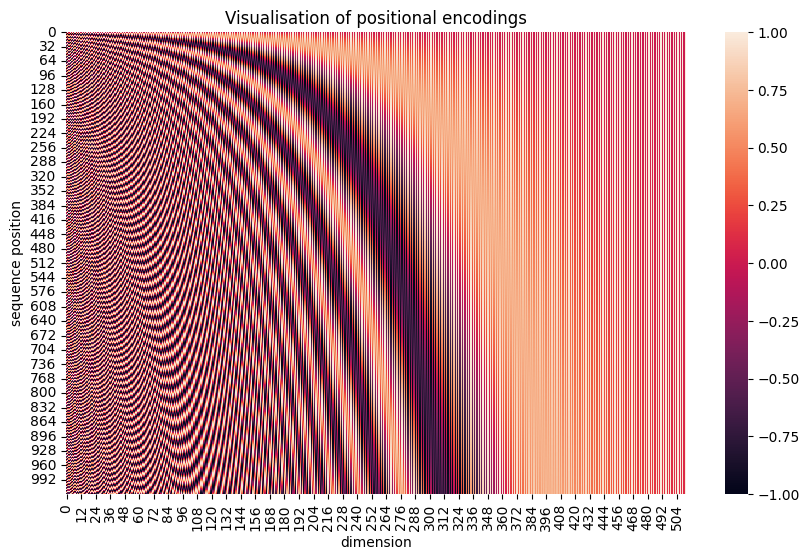

In [17]:
class PositionalEncoding(nn.Module):
    '''
    Positional Encoding Module.

    PE is computed by calling compute_pe().

    The PE applied to input embedding (sum of the input and PE) is returned by the forward().
    '''
    def __init__(self, d_model, max_seq_len):
        '''
        - d_model: dimensionality of embeddings (total)
        '''
        super().__init__()
        self.d_model = d_model #corresponds to the number of dimensions in our embeddings
        self.max_seq_len = max_seq_len # maximum length of the sequence that the model is expected to take as an input
        self.pe = self.compute_pe()

    def compute_pe(self):
        '''
        Returns:
            pe: torch.Tensor (1, max_seq_len, d_model), where 1 corresponds to a dummy batch size of 1
        '''
        pe = torch.zeros(1, max_seq_len, d_model) # empty template
        # TODO: implement the absolute positional encoding without an exponential decay (according to equation (3))
        # pe = ...
        # YOUR CODE HERE
        position = torch.arange(0, self.max_seq_len, dtype=torch.float).unsqueeze(1)
        log_10000 = torch.log(torch.tensor(10000.0))
        div_term = torch.exp(torch.arange(0, self.d_model, 2, dtype=torch.float) * (-log_10000 / self.d_model))
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        return pe

    def forward(self, x):
        '''
        Args:
            x: torch.Tensor (Batch_size, sequence_length, d_model)
        Returns:
            x_positional: torch:Tensor (Batch_size, sequence_length, d_model);
            NOTE: x_positional is the sum of the input AND the positional
            encodings (PE).
        '''
        # x_positional =
        # YOUR CODE HERE
        seq_len = x.size(1)
        x_positional = x + self.pe[:, :seq_len, :]
        return x_positional

positional_encoding = PositionalEncoding(d_model, max_seq_len)
pe = positional_encoding.compute_pe()
plot_encodings(pe)

In [18]:
print("Positional encoding for the sequence...")
res = positional_encoding(sequence)
print(f"Shape: {res.shape}")
print(f"First 10 values for the third batch, tenth token in the sequence: \n{res[2][9][:10]}")
print(f"Last 10 values for the third batch, tenth token in the sequence: \n{res[2][9][-10:]}")

Positional encoding for the sequence...
Shape: torch.Size([100, 25, 512])
First 10 values for the third batch, tenth token in the sequence: 
tensor([ 1.1136,  0.0325,  0.7804, -0.3728,  1.2179, -0.0267,  1.9070, -0.0467,
         1.2945,  0.2629])
Last 10 values for the third batch, tenth token in the sequence: 
tensor([0.7728, 1.2678, 0.3862, 1.5914, 0.2790, 1.4343, 0.8385, 1.3884, 0.1123,
        1.2560])


##### 1.5.5 Rotary positional embeddings [4 points]

Recall the transformer structure from [1].

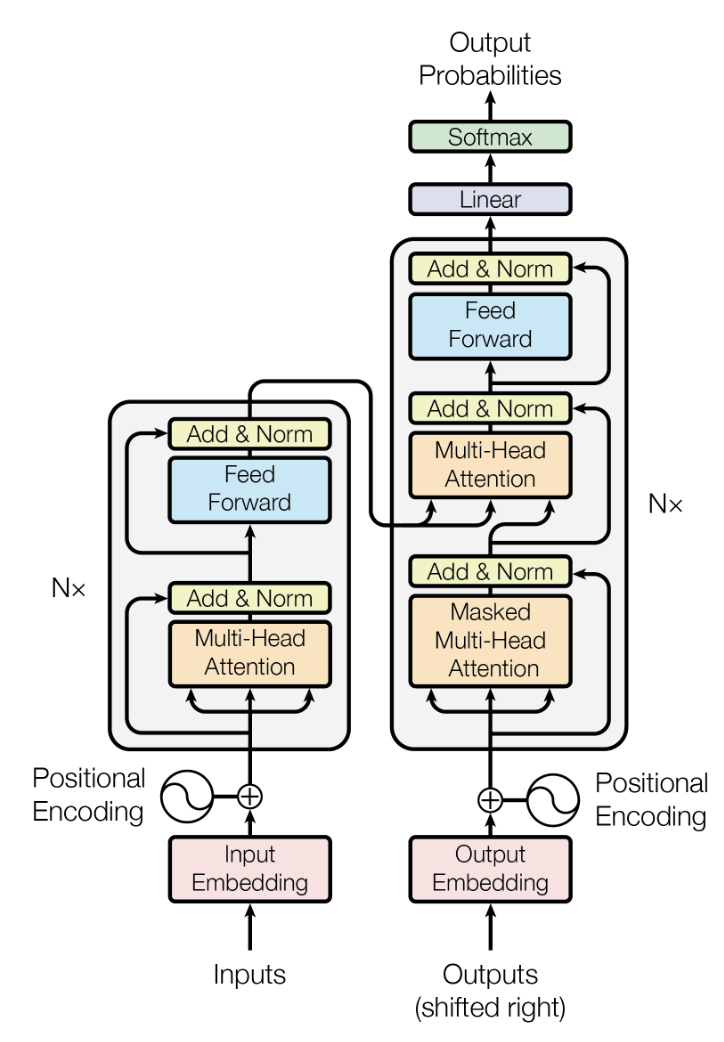

Read Sections 2.1, 2.2, 3.2.1, 3.2.2 of [2] to get familiar with the Rotary Position Embeddings. Consider how [2] proposes to abstract the problem.

"Let $\mathbb{S}_N = \{w_i\}_{i=1}^{N}$ be a sequence of $N$ input tokens with $w_i$ being the $i^{th}$ element. The corresponding word embedding of $\mathbb{S}_N$ is denoted as $\mathbb{E}_N = \{x_i\}_{i=1}^{N}$, where $x_i \in \mathbb{R}^{d}$ is the $d$-dimensional word embedding vector of token $w_i$ without position information."

**Summary:** $x_i$ is the $i$th position-agnostic input (represented as "inputs" in the diagram above). For example, in the sequence "The cat is on the mat", $x_1$ would correspond to the position-agnostic embedding of the word "cat", if we use word-level tokenization.

Note that the self-attention proposed in [1] first incorporates position information to the word embeddings (represented with "+" symbol in the diagram above), and then transforms them into queries, keys, and value representations in the attention block. "$q_m, k_n$, and $v_n$ incorporate the $m^{th}$ and $n^{th}$ positions through $f_q, f_k$, and $f_v$, respectively."[2]

$$
\begin{aligned}
    q_m &= f_q(x_m, m) \\
    k_n &= f_k(x_n, n) \\
    v_n &= f_v(x_n, n),
\end{aligned}
$$

**Summary:** [2] defines the $f_q$, $f_k$ and $f_v$ as the functions that take a position-agnostic embeddings $x_i$ and the position value $i$ to output the values that are later used in attention block.

**TODO**: Based on the diagram and notation above, write equations that formalise $f_q$, $f_k$, and $f_v$ for the paper [1].

**WRITE YOUR ANSWER HERE**

$$
f_q(x_m, m) = W^Q \Bigl( x_m + PE(m) \Bigr), \\
f_k(x_n, n) = W^K \Bigl( x_n + PE(n) \Bigr), \\
f_v(x_n, n) = W^V \Bigl( x_n + PE(n) \Bigr).
$$


"The query and key values are then used to compute the attention weights, while the output is computed as the weighted sum over the value." [2]

$$
a_{m,n} = \frac{\exp\left(\frac{\mathbf{q}_m^{\top} \mathbf{k}_n}{\sqrt{d}}\right)}
{\sum_{j=1}^{N} \exp\left(\frac{\mathbf{q}_m^{\top} \mathbf{k}_j}{\sqrt{d}}\right)}
$$

$$
\mathbf{o}_m = \sum_{n=1}^{N} a_{m,n} \mathbf{v}_n
$$

**Summary:** this equation reflects the computation of the attention weights, and the output coputation that you saw in the 1.5.1 and 1.5.2.

Sinusoidal positional encoding [1] takes an incorporates an **absolute** position of a token within a sequence. We also want to encorporate a **relative** distance between the tokens.  

"In order to incorporate relative position information, we require the inner product of query $\mathbf{q}_m$ and key $\mathbf{k}_n$ to be formulated by a function $g$, which takes only the word embeddings $x_m, x_n$, and their relative position $m - n$ as input variables. In other words, we hope that the inner product encodes position information only in the relative form:" [2]
$$
\langle f_q(x_m, m), f_k(x_n, n) \rangle = g(x_m, x_n, m - n).
$$
"The ultimate goal is to find an equivalent encoding mechanism to solve the functions $f_q(x_m, m)$ and $f_k(x_n, n)$ to conform to the aforementioned relation." [2]

**Summary**: as a result of mathematical computations, the authors of [2] proposed a formulation below (2D case shown for simplification) for the $f_k$ and $f_q$:

$$f_{\{q,k\}}(x_m, m) =
\begin{pmatrix}
\cos m\theta & -\sin m\theta \\
\sin m\theta & \cos m\theta
\end{pmatrix}
\begin{pmatrix}
W_{\{q,k\}}^{(11)} & W_{\{q,k\}}^{(12)} \\
W_{\{q,k\}}^{(21)} & W_{\{q,k\}}^{(22)}
\end{pmatrix}
\begin{pmatrix}
x_m^{(1)} \\
x_m^{(2)}
\end{pmatrix}.
$$

"In order to generalize our results in 2D to any $x_i \in \mathbb{R}^d$ where $d$ is even, we divide the $d$-dimension space into $d/2$ sub-spaces and combine them in the merit of the linearity of the inner product, turning $f_{\{q,k\}}$ into:" [2]

$$
f_{\{q,k\}}(x_m, m) = R_{\Theta,m}^{d} W_{\{q,k\}} x_m
$$

where

$$
R_{\Theta,m}^{d} =
\begin{pmatrix}
\cos m\theta_1 & -\sin m\theta_1 & 0 & 0 & 0 & \cdots & 0 & 0 \\
\sin m\theta_1 & \cos m\theta_1 & 0 & 0 & 0 & \cdots & 0 & 0 \\
0 & 0 & \cos m\theta_2 & -\sin m\theta_2 & 0 & \cdots & 0 & 0 \\
0 & 0 & \sin m\theta_2 & \cos m\theta_2 & 0 & \cdots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & 0 & 0 & \cos m\theta_{d/2} & -\sin m\theta_{d/2} & 0 \\
0 & 0 & 0 & 0 & 0 & \sin m\theta_{d/2} & \cos m\theta_{d/2} & 0
\end{pmatrix}
$$


is the rotary matrix with pre-defined parameters $\Theta = \{\theta_i = 10000^{-2(i-1)/d}, i \in [1, \dots, d/2]\}$.

RoPE approach is then applied in the following way in the attention block:

$$
q_m^\top k_n = (R_{\Theta,m}^{d} W_q x_m)^\top (R_{\Theta,n}^{d} W_k x_n) = x^\top W_q R_{\Theta,n-m}^{d} W_k x_n
$$

**TODO**: describe two key differences between RoPE and absolute (sinusoidal) positional encodings in **no more** than 2 sentences.

**WRITE YOUR ANSWER HERE**

RoPE encodes positional information by rotating token embeddings based on their positions, so that the inner product of queries and keys directly reflects the relative distance (\(n-m\)) between tokens. In contrast, absolute sinusoidal positional encodings add fixed, position-dependent vectors to the embeddings, requiring the model to infer relative positions indirectly.